In [2]:
import atlite
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
import os
import numpy as np
import pandas as pd

In [3]:
import os
import pandas as pd 
import numpy as np
import geopandas as gpd

from pyproj import Transformer
from pyproj import CRS, Proj

from osgeo import gdal 
import rasterio
from rasterio.windows import from_bounds
from shapely.geometry import Point
import matplotlib.pyplot as plt


import xarray as xr
import geopy.distance
import pickle
from scipy.constants import physical_constants

# Creating Zone Profiles

In [4]:
runoff = xr.open_dataarray("Cutouts_atlite/Laos5AVG_Runoff.nc")

FileNotFoundError: [Errno 2] No such file or directory: b'c:\\Users\\ls2823\\OneDrive - Imperial College London\\0_PUBLICATION\\Repositories\\GeoH2-Laos\\Cutouts_atlite\\Laos5AVG_Runoff.nc'

In [5]:
gdf_25 = gpd.read_file("Data_25\hydropower_dams_25.gpkg")
gdf_30 = gpd.read_file("Data_30\hydropower_dams_30.gpkg")

gdf_areas = gpd.read_file(r'C:\Users\ls2823\OneDrive - Imperial College London\0_PUBLICATION\Repositories\GeoH2-prep-Laos\Raw_Spatial_Data\areas_laos.geojson')


In [6]:
gdf_30

,SNo,New Ose_Name,name,Status,Fuel Type,Latitude,Longitude,Total capacity (MW),Domestic Capacity (MW),Expected Generation (GWh),total theoretical possible generation (local) GWh,COD,head,geometry
0,1,PWRHYD001NOR,Nam Ngum 1,Existing,Reservoir,18.530336,102.547646,155.0,155.00,1025.0,1357.800,1971.0,45.5,POINT (102.54765 18.53034)
1,2,PWRHYD002SOU,Xeset1,Existing,Run - Off,15.491752,106.278715,45.0,45.00,180.0,394.200,1991.0,10.0,POINT (106.27872 15.49175)
2,3,PWRHYD003CEN,Theun Hinboun(extension),Existing,Reservoir,18.261088,104.562496,440.0,0.05,2691.0,0.438,2013.0,27.0,POINT (104.56250 18.26109)
3,4,PWRHYD004SOU,Houay Ho,Existing,Reservoir,15.059603,106.764106,152.0,2.00,450.0,17.520,1999.0,79.0,POINT (106.76411 15.05960)
4,5,PWRHYD005NOR,Nam Leuk,Existing,Reservoir,18.437522,102.947408,60.0,60.00,215.0,525.600,2000.0,45.5,POINT (102.94741 18.43752)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,142,PWRHYD119SOU,Houay Palaiy,Expected to be completed after 2027,Reservoir,15.303814,106.001605,26.0,0.00,97.0,0.000,2027.0,10.0,POINT (106.00160 15.30381)
112,168,PWRHYD131SOU,Xekong (Downstream) B,Expected to be completed before 2030,Reservoir,14.851590,106.849223,50.0,NaN,206.3,NaN,2028.0,55.0,POINT (106.84922 14.85159)
113,188,PWRHYD139SOU,Xekong 4A,Expected to be completed after 2030,Reservoir,15.512723,106.787302,175.0,15.00,781.2,131.400,2030.0,53.0,POINT (106.78730 15.51272)
114,189,PWRHYD140SOU,Xekong 4B,Expected to be completed after 2030,Reservoir,15.795484,106.757473,165.0,15.00,749.5,131.400,2030.0,74.0,POINT (106.75747 15.79548)


In [75]:
def assign_zones_to_plants(plants_gdf, areas_gdf, zone_column="Area_new24"):
    """
    Assign zones to hydropower plants based on their spatial location.

    Args:
        plants_gdf (GeoDataFrame): GeoDataFrame containing hydropower plant locations.
        areas_gdf (GeoDataFrame): GeoDataFrame containing zone polygons with the `zone_column`.
        zone_column (str): Column name in `areas_gdf` representing zones.

    Returns:
        GeoDataFrame: Updated plants GeoDataFrame with assigned zones.
    """
    # Ensure both GeoDataFrames have the same CRS
    plants_gdf = plants_gdf.to_crs(areas_gdf.crs)

    # Perform spatial join to assign zones
    plants_with_zones = gpd.sjoin(plants_gdf, areas_gdf[[zone_column, "geometry"]], how="left", op="intersects")

    # Drop duplicate geometry columns if any
    plants_with_zones = plants_with_zones.drop(columns=["index_right"])

    return plants_with_zones


In [12]:
# Load spatial data
plants_gdf = gdf_30  # Replace with gdf30 if needed
# Step 1: Assign zones to plants
plants_with_zones = assign_zones_to_plants(plants_gdf, gdf_areas)


c:\Users\ls2823\AppData\Local\anaconda3\envs\geoh2_master\Lib\site-packages\IPython\core\interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [80]:
# File path and sheet mappings
excel_path = r'C:\Users\ls2823\OneDrive - Imperial College London\0_PUBLICATION\Repositories\GeoH2-prep-Laos\Raw_Spatial_Data\Load_profile.xlsx'
sheets = {
    'north': 'TimeSlices_Northern',
    'centre': 'TimeSlices_Central',
    'south': 'TimeSlices_Southern'
}
monthly_columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
hours_in_month = {
    'Jan': 744, 'Feb': 672, 'Mar': 744, 'Apr': 720,
    'May': 744, 'Jun': 720, 'Jul': 744, 'Aug': 744,
    'Sep': 720, 'Oct': 744, 'Nov': 720, 'Dec': 744
}

In [81]:
def load_and_process_load_profiles(excel_path, sheets, monthly_columns, hours_in_month, adjustment_factor=1.0):
    """
    Load and process load profiles from an Excel file for each zone, with a uniform adjustment factor.

    Args:
        excel_path (str): Path to the Excel file containing load profiles.
        sheets (dict): Mapping of zone names to sheet names in the Excel file.
        monthly_columns (list): List of columns representing months.
        hours_in_month (dict): Dictionary mapping months to the number of hours.
        adjustment_factor (float, optional): Uniform adjustment factor for all zones. Default is 1.0 (no adjustment).

    Returns:
        dict: A dictionary mapping zone names to expanded hourly load profiles (pd.Series).
    """
    zone_profiles = {}

    for zone, sheet in sheets.items():
        # Load the sheet
        zone_data = pd.read_excel(excel_path, sheet_name=sheet, index_col=0)

        # Expand the daily profile for each month
        hourly_demand = []
        for month_idx, hours in enumerate(hours_in_month.values()):
            avg_day_profile = zone_data.iloc[month_idx, :]  # Get daily values for the month
            expanded_monthly_profile = list(avg_day_profile) * (hours // 24)
            hourly_demand.extend(expanded_monthly_profile)

        # Create a Series with the hourly demand and apply the adjustment factor
        hourly_demand_series = pd.Series(
            hourly_demand,
            index=pd.date_range(start="2023-01-01 00:00", end="2023-12-31 23:00", freq="H")
        ) * adjustment_factor

        # Store the Series in the dictionary
        zone_profiles[zone] = hourly_demand_series

    return zone_profiles


In [85]:
# 2025 - 1.367125525
# 2030 - 1.804013066

adjustment_factor = 1.367125525  # Increase demand by 20% for all zones

# Call the function with the adjustment factor
zone_profiles = load_and_process_load_profiles(
    excel_path=excel_path,
    sheets=sheets,
    monthly_columns=monthly_columns,
    hours_in_month=hours_in_month,
    adjustment_factor=adjustment_factor
)

C:\Users\ls2823\AppData\Local\Temp\ipykernel_28500\57946921.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index=pd.date_range(start="2023-01-01 00:00", end="2023-12-31 23:00", freq="H")
C:\Users\ls2823\AppData\Local\Temp\ipykernel_28500\57946921.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index=pd.date_range(start="2023-01-01 00:00", end="2023-12-31 23:00", freq="H")
C:\Users\ls2823\AppData\Local\Temp\ipykernel_28500\57946921.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index=pd.date_range(start="2023-01-01 00:00", end="2023-12-31 23:00", freq="H")


In [83]:
with open("Parameters/zone_profiles_30.pkl", "wb") as f:
    pickle.dump(zone_profiles, f)

# Creating Net Generation

In [86]:
zone_profiles

{'north': 2023-01-01 00:00:00    550.573502
 2023-01-01 01:00:00    543.677851
 2023-01-01 02:00:00    541.267071
 2023-01-01 03:00:00    540.413387
 2023-01-01 04:00:00    547.929741
                           ...    
 2023-12-31 19:00:00    672.450369
 2023-12-31 20:00:00    631.049266
 2023-12-31 21:00:00    601.207871
 2023-12-31 22:00:00    576.071460
 2023-12-31 23:00:00    563.020483
 Freq: h, Length: 8760, dtype: float64,
 'centre': 2023-01-01 00:00:00    380.392328
 2023-01-01 01:00:00    374.306415
 2023-01-01 02:00:00    369.295194
 2023-01-01 03:00:00    369.719929
 2023-01-01 04:00:00    378.428328
                           ...    
 2023-12-31 19:00:00    645.283350
 2023-12-31 20:00:00    601.211379
 2023-12-31 21:00:00    555.176288
 2023-12-31 22:00:00    512.382336
 2023-12-31 23:00:00    494.824537
 Freq: h, Length: 8760, dtype: float64,
 'south': 2023-01-01 00:00:00     80.041230
 2023-01-01 01:00:00     79.441018
 2023-01-01 02:00:00     78.960319
 2023-01-01 03:00

In [20]:
def distribute_and_subtract_demand_v2(hourly_generation, zone_profiles, plants_data, zone_column):
    """
    Distribute zone-specific hourly demand across plants within each zone,
    and subtract demand from the plants' generation using dynamic hourly capacity.

    Args:
        hourly_generation (pd.DataFrame): Hourly generation values for all plants (time x plants).
        zone_profiles (dict): Dictionary mapping zones to their expanded hourly load profiles.
        plants_data (GeoDataFrame): Plant data containing assigned zones.
        zone_column (str): Column name indicating plant zone ('north', 'centre', 'south').

    Returns:
        pd.DataFrame: Net hourly generation values (time x plants).
    """
    # Initialize a DataFrame to store net generation
    net_generation = hourly_generation.copy()

    # Iterate over each zone
    for zone, hourly_zone_demand in zone_profiles.items():
        # Filter plants belonging to the current zone
        plants_in_zone = plants_data[plants_data[zone_column] == zone]
        zone_plant_names = plants_in_zone['name']

        # If no plants in this zone, skip it
        if zone_plant_names.empty:
            continue

        # Extract hourly generation for the plants in the current zone
        zone_hourly_generation = hourly_generation[zone_plant_names]

        # Calculate the total hourly generation for the zone
        total_hourly_generation = zone_hourly_generation.sum(axis=1)

        # Avoid division by zero: replace zeros with NaN temporarily
        total_hourly_generation.replace(0, float('nan'), inplace=True)

        # Distribute demand among plants in the zone based on their hourly generation
        for plant in zone_plant_names:
            # Fractional demand based on hourly generation share
            fractional_demand = (
                (zone_hourly_generation[plant] / total_hourly_generation) * hourly_zone_demand
            )

            # Fill NaN values in fractional_demand with 0 (for cases where total_hourly_generation was 0)
            fractional_demand.fillna(0, inplace=True)

            # Subtract demand from the plant's generation
            net_generation[plant] -= fractional_demand

    return net_generation


In [ ]:
net_generation_wet = distribute_and_subtract_demand_v2(
    hourly_generation=hourly_values_wet,  # Hourly generation DataFrame
    zone_profiles=zone_profiles,         # Zone-specific hourly demand profiles
    plants_data=plants_with_zones,       # Plant data with zones
    zone_column="Area_new24"             # Zone column name
)

In [21]:
def plot_net_generation(net_generation, plants_data, zone_column, max_hours=None):
    """
    Plot the net generation over time for each zone with an optional hour limit.

    Args:
        net_generation (pd.DataFrame): Net hourly generation values (time x plants).
        plants_data (GeoDataFrame): Plant data containing assigned zones.
        zone_column (str): Column name indicating plant zone ('north', 'centre', 'south').
        max_hours (int, optional): Maximum number of hours to display. Defaults to None (show all hours).

    Returns:
        None
    """
    # Limit the data to the first `max_hours` if specified
    if max_hours:
        net_generation = net_generation.iloc[:max_hours]

    # Create an hour index (1 to total hours in net_generation)
    hour_index = range(1, len(net_generation) + 1)

    # Group plants by zone
    zones = plants_data[zone_column].unique()

    plt.figure(figsize=(12, 6))

    for zone in zones:
        # Get plants in this zone
        plants_in_zone = plants_data[plants_data[zone_column] == zone]['name']

        # Aggregate net generation for the zone
        zone_net_generation = net_generation[plants_in_zone].sum(axis=1)

        # Plot the zone's net generation
        plt.plot(hour_index, zone_net_generation, label=f"{zone.capitalize()} Zone")

    # Customize the plot
    plt.title(f"Net Generation Over Hours by Zone ({'All Hours' if not max_hours else f'First {max_hours} Hours'})")
    plt.xlabel("Hour")
    plt.ylabel("Net Generation (MW)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Plot only the first 1000 hours
plot_net_generation(
    net_generation=net_generation_wet,
    plants_data=plants_with_zones,
    zone_column="Area_new24",
    # max_hours=700
)

NameError: name 'net_generation_wet' is not defined

## In the Optimisation

In [3]:

def hydropower_potential(eta,flowrate,head):
    '''
    Calculate hydropower potential in Megawatts

    Parameters
    ----------
    eta : float
        Efficiency of the hydropower plant.
    flowrate : float
        Flowrate calculated with runoff multiplied by the hydro-basin area, in cubic meters per hour.
    head : float
        Height difference at the hydropower site, in meters.

    Returns
    -------
    float
        Hydropower potential in Megawatts (MW).
    '''
    rho = 997 # kg/m3; Density of water
    g = physical_constants['standard acceleration of gravity'][0] # m/s2; Based on the CODATA constants 2018
    Q = (flowrate/(1000/24)) / 3600 # transform flowrate per h into flowrate per second
    return (eta * rho * g * Q * head) / (1000 * 1000) # MW

def hydropower_potential_with_capacity(flowrate, head, capacity, eta):
    '''
    Calculate the hydropower potential considering the capacity limit

    Parameters
    ----------
    flowrate : float
        Flowrate calculated with runoff multiplied by the hydro-basin area, in cubic meters per hour.
    head : float
        Height difference at the hydropower site, in meters.
    capacity : float
        Maximum hydropower capacity in Megawatts (MW).
    eta : float
        Efficiency of the hydropower plant.

    Returns
    -------
    xarray DataArray
        Capacity factor, which is the limited potential divided by the capacity.
    '''
    potential = hydropower_potential(flowrate, head, eta)
    limited_potential = xr.where(potential > capacity, capacity, potential)
    capacity_factor = limited_potential / capacity
    return capacity_factor


In [11]:
def assign_zones_to_plants(plants_gdf, areas_gdf, zone_column="Area_new24"):
    """
    Assign zones to hydropower plants based on their spatial location.

    Args:
        plants_gdf (GeoDataFrame): GeoDataFrame containing hydropower plant locations.
        areas_gdf (GeoDataFrame): GeoDataFrame containing zone polygons with the `zone_column`.
        zone_column (str): Column name in `areas_gdf` representing zones.

    Returns:
        GeoDataFrame: Updated plants GeoDataFrame with assigned zones.
    """
    # Ensure both GeoDataFrames have the same CRS
    plants_gdf = plants_gdf.to_crs(areas_gdf.crs)

    # Perform spatial join to assign zones
    plants_with_zones = gpd.sjoin(plants_gdf, areas_gdf[[zone_column, "geometry"]], how="left", op="intersects")

    # Drop duplicate geometry columns if any
    plants_with_zones = plants_with_zones.drop(columns=["index_right"])

    return plants_with_zones


In [141]:
hexagons = gpd.read_file(f'Parameters_PEM_25/hex_transport.geojson')
runoff = xr.open_dataarray("Cutouts_atlite/Laos5AVG_Runoff.nc")

gdf_areas = gpd.read_file(r'Parameters\areas_laos.geojson')

In [142]:
location_hydro = gpd.read_file(f'Data_25/hydropower_dams_25.gpkg')
location_hydro.rename(columns={'Latitude': 'lat', 'Longitude': 'lon'}, inplace=True)
# location_hydro.rename(columns={'head_example':'head'},inplace=True)

location_hydro['geometry'] = gpd.points_from_xy(location_hydro.lon, location_hydro.lat)
# --->>>>
# USE PLANTS_WITH_ZONES
location_hydro = assign_zones_to_plants(location_hydro, gdf_areas)

# laos_hydrobasins = gpd.read_file('Data_hydrobasins/hydrobasins_lvl10/hybas_as_lev10_v1c.shp')
# laos_hydrobasins['lat'] = location_hydro.geometry.y
# laos_hydrobasins['lon'] = location_hydro.geometry.x




c:\Users\ls2823\AppData\Local\anaconda3\envs\geoh2_master\Lib\site-packages\IPython\core\interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [129]:
with open("Parameters/zone_profiles_30.pkl", "rb") as f:
    zone_profiles = pickle.load(f)

In [130]:
eta = 0.75  # efficiency of hydropower plant

# Calculate the capacity factor
capacity_factor = xr.apply_ufunc(
    hydropower_potential_with_capacity,
    runoff,
    xr.DataArray(location_hydro['head'].values, dims=['plant']),
    xr.DataArray(location_hydro['Total capacity (MW)'].values, dims=['plant']),
    eta,
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
)

# Rename existing 'index_left' and 'index_right' columns if they exist
if 'index_left' in location_hydro.columns:
    location_hydro = location_hydro.rename(columns={'index_left': 'index_left_renamed'})
if 'index_right' in location_hydro.columns:
    location_hydro = location_hydro.rename(columns={'index_right': 'index_right_renamed'})
if 'index_left' in hexagons.columns:
    hexagons = hexagons.rename(columns={'index_left': 'index_left_renamed'})
if 'index_right' in hexagons.columns:
    hexagons = hexagons.rename(columns={'index_right': 'index_right_renamed'})

# Map plants to hexagons
hydro_hex_mapping = gpd.sjoin(location_hydro, hexagons, how='left', predicate='within')
hydro_hex_mapping['plant_index'] = hydro_hex_mapping.index

num_hexagons = len(hexagons)
num_time_steps = len(capacity_factor.time)


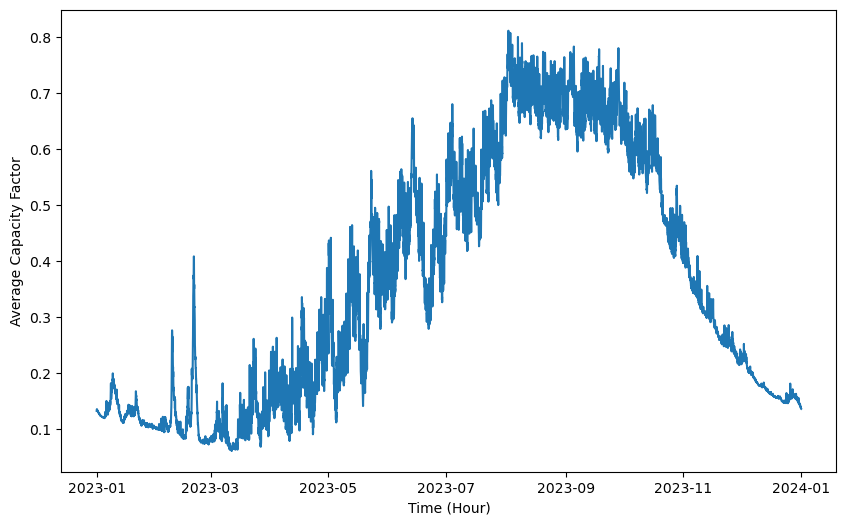

In [131]:
hourly_average = capacity_factor.mean(dim='plant')
plt.figure(figsize=(10, 6))
plt.plot(hourly_average['time'], hourly_average.values)
plt.xlabel('Time (Hour)')
plt.ylabel('Average Capacity Factor')
plt.show()

In [132]:
with open("Parameters/zone_profiles_30.pkl", "rb") as f:
    zone_profiles = pickle.load(f)

In [133]:

# Initialize the output profile
hydro_profile = xr.DataArray(
    data=np.zeros((num_hexagons, num_time_steps)),
    dims=['hexagon', 'time'],
    coords={'hexagon': np.arange(num_hexagons), 'time': capacity_factor.time}
)

# Prepare zone-specific demand for subtraction
zone_demand = pd.DataFrame(zone_profiles)


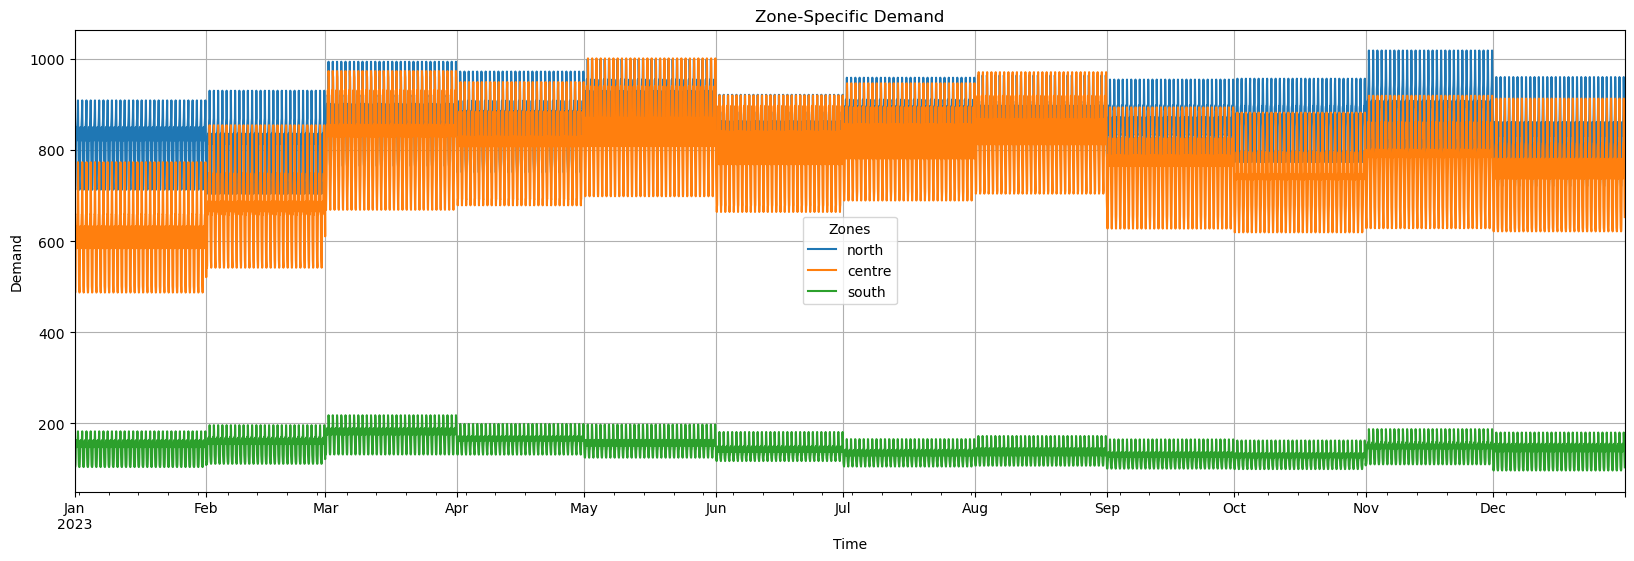

In [134]:
zone_demand.plot(figsize=(20, 6))
plt.title("Zone-Specific Demand")
plt.xlabel("Time")
plt.ylabel("Demand")
plt.legend(title="Zones")
plt.grid()
plt.show()

In [135]:
def calculate_net_generation(absolute_generation, zone_profiles, plants_with_zones, zone_column):
    """
    Distribute zone-specific hourly demand across plants within each zone,
    and subtract demand from the plants' absolute generation.

    Parameters:
        absolute_generation (xr.DataArray): Absolute generation (MW) for all plants (plants x time).
        zone_profiles (dict): Dictionary mapping zones to their expanded hourly load profiles.
        plants_with_zones (gpd.GeoDataFrame): Plant data with assigned zones and other attributes.
        zone_column (str): Column name in `plants_with_zones` indicating plant zone (e.g., 'north', 'centre', 'south').

    Returns:
        xr.DataArray: Net hourly generation values (plants x time).
    """
    # Create a copy for net generation
    net_generation = absolute_generation.copy()

    # Iterate over each zone
    for zone, hourly_zone_demand in zone_profiles.items():
        # Filter plants belonging to the current zone
        plants_in_zone = plants_with_zones[plants_with_zones[zone_column] == zone]
        plants_in_zone_indices = plants_in_zone.index.tolist()

        if not plants_in_zone_indices:
            continue  # Skip if no plants in the zone

        # Select absolute generation for the plants in the current zone
        zone_generation = absolute_generation.sel(plant=plants_in_zone_indices)

        # Calculate the total hourly generation for the zone
        total_hourly_generation = zone_generation.sum(dim="plant")
        # Avoid division by zero: replace zeros with NaN temporarily
        total_hourly_generation = total_hourly_generation.where(total_hourly_generation != 0, other=np.nan)

        # Distribute demand among plants in the zone based on their hourly generation share
        for plant_index in plants_in_zone_indices:
            # Fractional demand based on hourly generation share
            fractional_demand = (
                (zone_generation.sel(plant=plant_index) / total_hourly_generation) * hourly_zone_demand.values
            )

            # Replace NaN values in fractional_demand with 0
            fractional_demand = fractional_demand.fillna(0)

            # Subtract demand from the plant's generation
            net_generation.loc[dict(plant=plant_index)] -= fractional_demand
    
    return net_generation


In [136]:
# Calculate absolute generation (MW)
absolute_generation = capacity_factor * xr.DataArray(
    location_hydro['Domestic Capacity (MW)'].values, dims=['plant']
)

# Calculate net generation
net_generation = calculate_net_generation(
    absolute_generation=absolute_generation,
    zone_profiles=zone_demand,
    plants_with_zones=location_hydro,
    zone_column="Area_new24"
)

In [137]:
def visualize_net_generation(net_generation, plants_data, zone_column, plot_type="aggregated", max_hours=None):
    """
    Visualize the net generation.

    Args:
        net_generation (xr.DataArray): The net generation data (plants x time).
        plants_data (GeoDataFrame): Plant metadata containing zone information.
        zone_column (str): The column in `plants_data` indicating the zone.
        plot_type (str): "aggregated" to show total net generation by zone, 
                         or "individual" for specific plants.
        max_hours (int): Limit the number of hours to visualize (optional).
    """
    if max_hours is None:
        max_hours = len(net_generation.time)

    if plot_type == "aggregated":
        # Aggregate net generation by zones
        zones = plants_data[zone_column].unique()
        zone_data = {}
        for zone in zones:
            plants_in_zone = plants_data[plants_data[zone_column] == zone].index.tolist()
            zone_net_gen = net_generation.sel(plant=plants_in_zone).sum(dim="plant")
            zone_data[zone] = zone_net_gen.isel(time=slice(0, max_hours)).values

        # Plot aggregated net generation
        plt.figure(figsize=(12, 6))
        for zone, data in zone_data.items():
            plt.plot(net_generation.time[:max_hours], data, label=f"{zone} Zone")
        
        plt.title("Aggregated Net Generation by Zone")
        plt.xlabel("Time")
        plt.ylabel("Net Generation (MW)")
        plt.legend()
        plt.grid()
        plt.show()

    elif plot_type == "individual":
        # Plot individual plants' net generation
        plt.figure(figsize=(12, 6))
        for plant_idx in net_generation.plant[:100]:  # Limit to first 5 plants for readability
            plt.plot(
                net_generation.time[:max_hours],
                net_generation.sel(plant=plant_idx).isel(time=slice(0, max_hours)).values,
                label=f"Plant {plant_idx.values}",
            )
        
        plt.title("Net Generation for Individual Plants")
        plt.xlabel("Time")
        plt.ylabel("Net Generation (MW)")
        plt.legend()
        plt.grid()
        plt.show()

    else:
        raise ValueError("Invalid plot_type. Use 'aggregated' or 'individual'.")


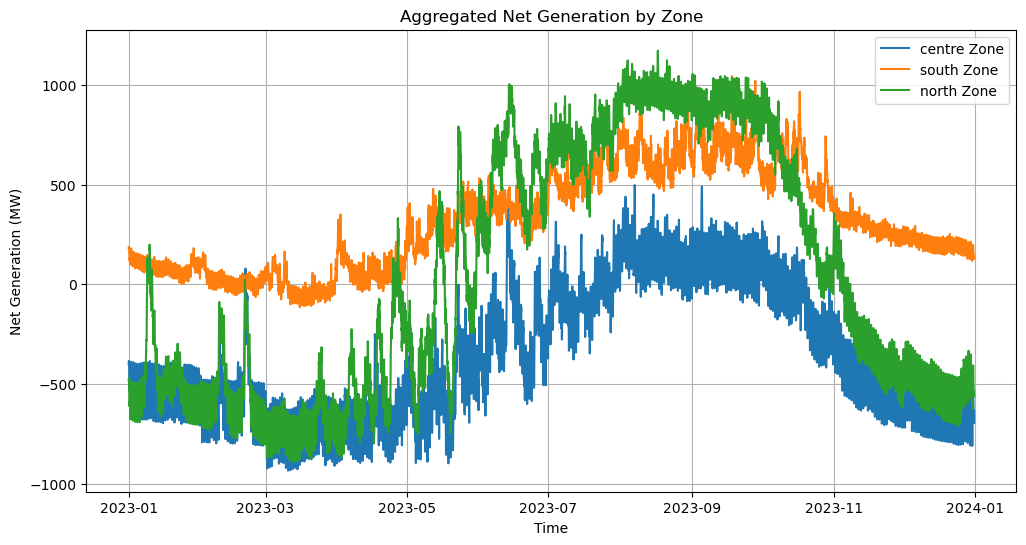

In [138]:
visualize_net_generation(
    net_generation=net_generation,
    plants_data=location_hydro,
    zone_column="Area_new24",
    plot_type="aggregated",
    max_hours=8750  # Optional: Limit to first 1000 hours
)


In [139]:
# Initialize hydro profile DataArray
hydro_profile = xr.DataArray(
    data=np.zeros((num_hexagons, num_time_steps)),
    dims=["hexagon", "time"],
    coords={"hexagon": np.arange(num_hexagons), "time": capacity_factor.time},
)

# Loop over hexagons
for hex_index in range(num_hexagons):
    # Get plants in the current hexagon
    plants_in_hex = hydro_hex_mapping[hydro_hex_mapping["index_right"] == hex_index]["plant_index"].tolist()
    
    if len(plants_in_hex) > 0:
        # Select net generation and plant capacities for these plants
        hex_net_generation = net_generation.sel(plant=plants_in_hex)
        plant_capacities = xr.DataArray(
            location_hydro.loc[plants_in_hex]["Domestic Capacity (MW)"].values,
            dims=["plant"]
        )
        # Calculate capacity factor as net generation / plant capacity
        capacity_factor_hex = hex_net_generation / plant_capacities
        
        # Ensure capacity factor is within [0, 1]
        capacity_factor_hex = xr.where(capacity_factor_hex > 1, 1, capacity_factor_hex)
        capacity_factor_hex = xr.where(capacity_factor_hex < 0, 0, capacity_factor_hex)

        # Weighted average capacity factor for the hexagon
        weights = plant_capacities / plant_capacities.sum()
        weighted_avg_capacity_factor = (capacity_factor_hex * weights).sum(dim="plant")
        hydro_profile.loc[dict(hexagon=hex_index)] = weighted_avg_capacity_factor


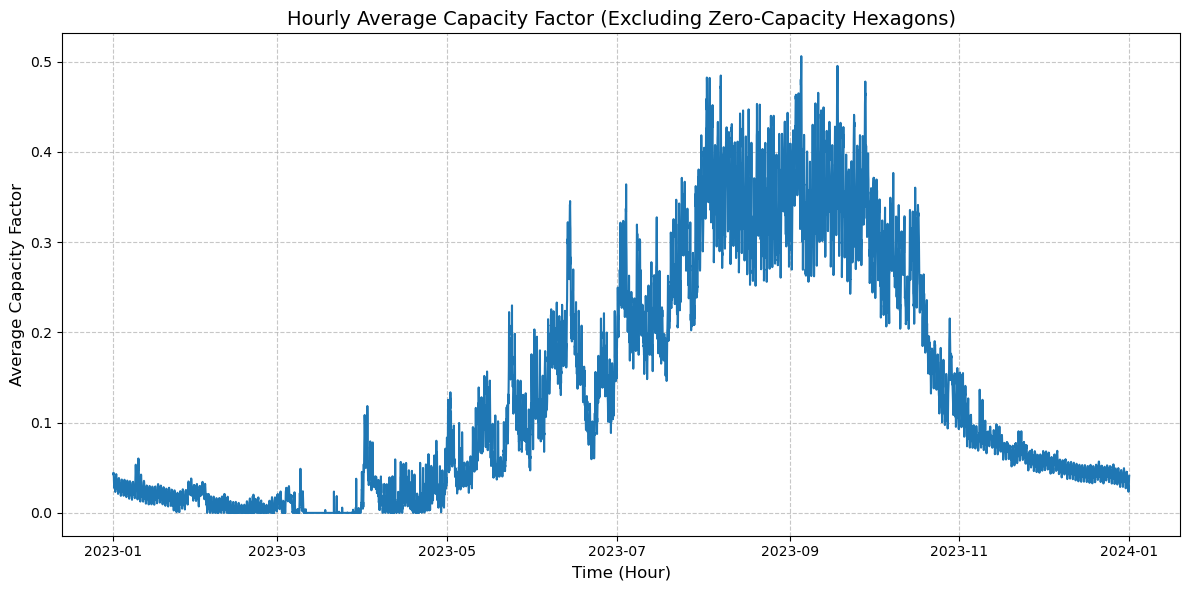

In [140]:
# Exclude hexagons that have solely 0 capacity factor
non_zero_hexagons = hydro_profile.max(dim="time") > 0
filtered_hydro_profile = hydro_profile.sel(hexagon=non_zero_hexagons)

# Calculate hourly average over the remaining hexagons
hourly_average = filtered_hydro_profile.mean(dim="hexagon")

# Visualize the result
plt.figure(figsize=(12, 6))
plt.plot(hourly_average["time"], hourly_average.values)
plt.title('Hourly Average Capacity Factor (Excluding Zero-Capacity Hexagons)', fontsize=14)
plt.xlabel('Time (Hour)', fontsize=12)
plt.ylabel('Average Capacity Factor', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### OLD Code

In [ ]:

eta = 0.75 # efficiency of hydropower plant

capacity_factor = xr.apply_ufunc(
    hydropower_potential_with_capacity,
    runoff,
    xr.DataArray(location_hydro['head'].values, dims=['plant']),
    xr.DataArray(location_hydro['Total capacity (MW)'].values, dims=['plant']), # Take total capacity to calculate the capacity factor, but domestic to multiply in Hexagons
    eta,
    vectorize=True,
    dask='parallelized',  # Dask for parallel computation
    output_dtypes=[float]
)

location_hydro['geometry'] = gpd.points_from_xy(location_hydro.lon, location_hydro.lat)


# Rename existing 'index_left' and 'index_right' columns if they exist
if 'index_left' in location_hydro.columns:
    location_hydro = location_hydro.rename(columns={'index_left': 'index_left_renamed'})
if 'index_right' in location_hydro.columns:
    location_hydro = location_hydro.rename(columns={'index_right': 'index_right_renamed'})
if 'index_left' in hexagons.columns:
    hexagons = hexagons.rename(columns={'index_left': 'index_left_renamed'})
if 'index_right' in hexagons.columns:
    hexagons = hexagons.rename(columns={'index_right': 'index_right_renamed'})

hydro_hex_mapping = gpd.sjoin(location_hydro, hexagons, how='left', predicate='within')
hydro_hex_mapping['plant_index'] = hydro_hex_mapping.index
num_hexagons = len(hexagons)
num_time_steps = len(capacity_factor.time)

hydro_profile = xr.DataArray(
    data=np.zeros((num_hexagons, num_time_steps)),
    dims=['hexagon', 'time'],
    coords={'hexagon': np.arange(num_hexagons), 'time': capacity_factor.time}
)

for hex_index in range(num_hexagons):
    plants_in_hex = hydro_hex_mapping[hydro_hex_mapping['index_right'] == hex_index]['plant_index'].tolist()
    if len(plants_in_hex) > 0:
        hex_capacity_factor = capacity_factor.sel(plant=plants_in_hex)
        plant_capacities = xr.DataArray(location_hydro.loc[plants_in_hex]['Domestic Capacity (MW)'].values, dims=['plant'])

        weights = plant_capacities / plant_capacities.sum()
        weighted_avg_capacity_factor = (hex_capacity_factor * weights).sum(dim='plant')
        hydro_profile.loc[hex_index] = weighted_avg_capacity_factor